# Applying DP to New York citibike data

Here's a demonstration of our 'integral' kernel. We use the citibike data.

**I've not actually added DP noise to the data in this example yet.**

We'll bin the data into a histogram, with two axes: Time since start of week and Duration of bike ride.

## Load the data

In [1]:
import pandas
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


df = pandas.read_csv('201606-citibike-tripdata.csv')#,nrows=1000000)

## Calculate 'seconds since start of week'

In [2]:
#seconds since start of week
seconds = np.zeros(df.shape[0])
dow = np.zeros(df.shape[0])
for i,p in enumerate(df.iterrows()):
    hiredatetime = datetime.strptime(p[1]['starttime'], '%m/%d/%Y %H:%M:%S')
    midnight = hiredatetime.replace(hour=0, minute=0, second=0, microsecond=0)
    dow[i] = hiredatetime.weekday()    
    seconds[i] = (hiredatetime - midnight).seconds + dow[i]*(3600*24.0)
df['seconds'] = seconds
df['dow'] = dow

In [3]:
#seconds since midnight
#seconds = np.zeros(df.shape[0])
#dow = np.zeros(df.shape[0])
#for i,p in enumerate(df.iterrows()):
#    hiredatetime = datetime.strptime(p[1]['starttime'], '%m/%d/%Y %H:%M:%S')
#    midnight = hiredatetime.replace(hour=0, minute=0, second=0, microsecond=0)
#    seconds[i] = (hiredatetime - midnight).seconds
#    dow[i] = hiredatetime.weekday()
#df['seconds'] = seconds
#df['dow'] = dow

## Methods to analyse data

 - bin_dataframe: Given a dataframe and a list of dimensions to use, generate a histogram of data (and provide the bin boundaries etc).
 - buildlist: Produces a matrix. Each row describes one bin. Each pair of columns describes the bin edges in one dimension.
 - findcentres: Produces a matrix, in which each column is a bin centre.
 - get_Gaussian_DP_noise: Calculate the sigma (standard deviation) value for the specified DP parameters.
 - generate_Gaussian_DP_noise: Generates DP noises of the required scale and shape

In [4]:
def buildlist(bins):
    #Produces a matrix. Each row describes one bin.
    #bins: a list of D numpy arrays (one for each dimension),
    #each one specifying the boundaries of each bin (Mx bins)
    #e.g. [np.array([1,2,3]),np.array([4,6,8,10])]
    #the arrays contain varying number of bin boundaries,
    #M1+1,M2+1..MD+1
    #
    #outputs: a D dimensional array containing the values
    #
    #returns
    #a matrix of size (M1*M2*...*MD) x (2*D)
    #each row is one bin in the D-dimensional histogram
    #each pair of columns are the boundary values of a bin
    #in one dimension, so in the example above the result
    #would be:
    # 1 2 4  6
    # 1 2 6  8
    # 1 2 8 10
    # 2 3 4  6
    # 2 3 6  8
    # 2 3 8 10
    #M1=2, M2=3, so the matrix size is (2*3) x (2*2) = 6x4
    #
    #This is the same order of items that feeding the histogram
    #into squeeze produces.
    boundaries = None
    for b1,b2 in zip(bins[0][0:-1],bins[0][1:]):
        if len(bins)>1:
            new = np.array(buildlist(bins[1:]))
            old = np.repeat(np.array([b1,b2])[None,:],len(new),axis=0)
            
            newrows = np.hstack([old,new])
            
        else:
            newrows = np.array([b1,b2])[None,:]
        if boundaries is None:
            boundaries = newrows
            
        else:
            boundaries = np.vstack([boundaries,newrows])

    return boundaries

def findcentres(area_row_list):
    #takes the matrix (Lx(2D)) buildlist returns and
    #finds the mean of each pair of bin boundaries
    #reults in an LxD matrix
    #
    #for the example given in buildlist's comment,
    #the output of this function would be:
    # 1.5 5
    # 1.5 7
    # 1.5 9
    # 2.5 5
    # 2.5 7
    # 2.5 9

    out = []
    for d in range(0,area_row_list.shape[1],2):
        out.append(np.mean(area_row_list[:,d:(d+2)],axis=1))
    return(np.array(out).T)

def get_Gaussian_DP_noise(epsilon,delta,sensitivity):
    csqr = 2*np.log(1.25/delta)
    sigma = np.sqrt(csqr)*sensitivity/epsilon
    return sigma

def generate_Gaussian_DP_noise(sigma,shape):
    noise = np.random.normal(0,sigma,shape)
    return noise

def bin_dataframe(df,axes,verbose=True):
#Bins the data in a dataframe, by the list of tuples in 'axes'.
#each tuple specifies the name of a column and the range and step size to bin it with, e.g.:
#[('seconds',0,24*3600,60*5),('gender',None,None,1)] or leave out the range,
#and just provide a single step size, and let the tool decide on the bounds
#
#returns:
#output = histogram
#represent the data of the histogram in a list:
#point_row_form = each row is one histogram cell's centroid location
#area_row_form = each row is one histogram cell's location, with the bounds specified
#output_row_form = each row is the value of that histogram cell
#bins = list of arrays, each one a list of boundaries for each bin


    bins = []
    for i,axis in enumerate(axes):
        column = axis[0]
        start = axis[1]
        end = axis[2]
        step = axis[3]
        if (start==None):
            s = df[column]
            s = s[~np.isnan(s)]
            s = np.sort(s)
            N = s.shape[0]
            start = s[int(N*0.03)] #get rid of outliers
            end = s[int(N*0.97)]
            delta= (end-start)*0.04 #add 10% on each end, to catch any outside the range.
            start -= delta
            end += delta
            #step = (end-start)/step            
        axes[i] = column,start,end,step
        bins.append(np.arange(start,end+step,step))
    data = df[[axis[0] for axis in axes]].as_matrix()
    
    output = np.histogramdd(data,bins)[0]
    if verbose:
        bincount = np.prod([len(b)-1 for b in bins])
        print("Bin count: %d" % bincount)
        datacount =  (df.shape[0])
        print("Data Length: %d" % datacount)
        print("Average occupancy: %0.2f" % (1.0*datacount/bincount))
        print("%0.2f%% of data were not included." % (100*(1-(np.sum(output)/df.shape[0]))))
    
    area_row_form = buildlist(bins)
    point_row_form = findcentres(area_row_form)
    output_row_form = output.flatten() #TODO: CHECK ORDER IS CORRECT
    #assert np.sum(output)==df.shape[0], "Not all data points have been counted"
    return output,point_row_form,area_row_form,output_row_form,bins

## Cycle hire times

To give you an idea of cyclist hire times, here's a plot of the hire times.

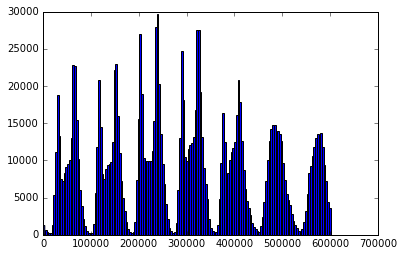

In [5]:
%matplotlib inline
plt.hist(seconds,range(0,24*60*60*7,60*60*1));

## Analyse the data

Here we specify the boundary list, and then produce a series of variables. We produce two similar sets, one is a 'lower resolution' histogram, containing larger bins (just 168 for the whole week, with just 3 bins for the trip duration).

output is the binned data, while point_row_form, area_row_form, output_row_form, bins are other variables describing the shape of the binning. 

output_test and associated variables are from a similar analysis, but with smaller bin sizes (contain 3024 bins for the whole week).

We train on the low-res data, and then test how well it predicts the hi-res data. We do this with the assumption that, in future, people will want to estimate the hi-res data using low-res binned data (e.g. from a differentially private treatment of a dataset).

In [48]:
#boundarylist = [('seconds',0,24*3600,60*30), ('dow',0.0,7.0,1.0)]#,('start station longitude',None,None,0.025),('start station latitude',None,None,0.025)]#,('gender',None,None,1.0),('birth year',None,None,10.0)],('dow',0.0,7.0,1.0)] #,('tripduration',None,None,600)]
boundarylist = [('seconds',0,24*3600*7,60*60*3), ('tripduration',0,3600,1200)]
test_boundarylist = [('seconds',0,24*3600*7,60*30), ('tripduration',0,3600,400)]
output,point_row_form,area_row_form,output_row_form,bins = bin_dataframe(df,boundarylist)
output_test,point_row_form_test,area_row_form_test,output_row_form_test,bins_test = bin_dataframe(df,test_boundarylist)
area = np.prod([b[3] for b in boundarylist])
area_test = np.prod([b[3] for b in test_boundarylist])


Bin count: 168
Data Length: 1460318
Average occupancy: 8692.37
1.05% of data were not included.
Bin count: 3024
Data Length: 1460318
Average occupancy: 482.91
1.05% of data were not included.


## Fit the two GP regression models

Here we fit two GP regression models to the low-res binned data. One uses the 'rbf' kernel, while the other uses the 'integral' kernel.

In [7]:
import GPy

sigma = get_Gaussian_DP_noise(1.0,0.01,4.0) #sensitivity=4 #eps

print output_row_form.shape
noisy_output = output_row_form + generate_Gaussian_DP_noise(sigma,len(output_row_form))

#initialise length scales to 5% size of data, as that'll probably be close-ish
init_length_scales = 0.05*np.array([np.max(b)-np.min(b) for b in bins]) #np.ones(point_row_form.shape[1])
kernel = GPy.kern.Multidimensional_Integral_Limits(input_dim=area_row_form.shape[1], variances=1.0, lengthscale=init_length_scales)
rbfkernel = GPy.kern.RBF(input_dim=point_row_form.shape[1], lengthscale=init_length_scales, ARD=True)
m = GPy.models.GPRegression(1.0*area_row_form,1.0*area*output_row_form[:,None],kernel)
#m.Gaussian_noise.variance.fix(0.2)
m.integral.variances = 1000000
m.Gaussian_noise.variance=1000000
m.optimize(messages=True)


m_rbf = GPy.models.GPRegression(1.0*point_row_form,1.0*output_row_form[:,None],rbfkernel)
#m.Gaussian_noise.variance.fix(0.2)
m_rbf.Gaussian_noise.variance=1000
m_rbf.optimize(messages=True)

(168,)


Temporary caching, so I don't have to rerun all the above code

In [16]:
%store m
%store m_rbf
%store df

Stored 'm' (GPRegression)
Stored 'm_rbf' (GPRegression)
Stored 'df' (DataFrame)


In [13]:
%store -r m
%store -r m_rbf
%store -r df

## Assessment

First we plot the 'integral' kernel's fit. We plot it for short rides and long rides. Notice, short rides are more popular in the week, while long hires are more common at the weekend & longer ones are less popular in general.

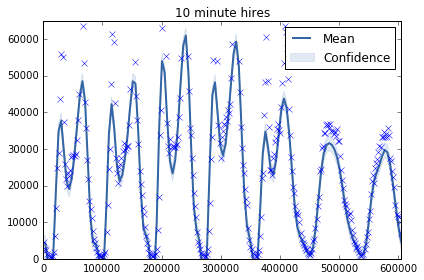

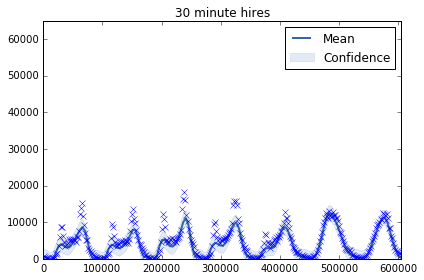

In [62]:
m.plot(fixed_inputs=[(1,0),(2,600),(3,0)],plot_data=False)
sel = point_row_form_test[:,1]==600
plt.plot(point_row_form_test[sel,0],output_row_form_test[sel]*area/area_test,'x')
plt.ylim([0,area*0.005])
plt.xlim([0,60*60*7*24])
plt.title('10 minute hires')

m.plot(fixed_inputs=[(1,0),(2,1800),(3,0)],plot_data=False)
sel = point_row_form_test[:,1]==1800
plt.plot(point_row_form_test[sel,0],output_row_form_test[sel]*area/area_test,'x')
plt.ylim([0,area*0.005])
plt.xlim([0,60*60*7*24])
plt.title('30 minute hires')

Similarly we look at the results of using the rbf kernel:

(0, 604800)

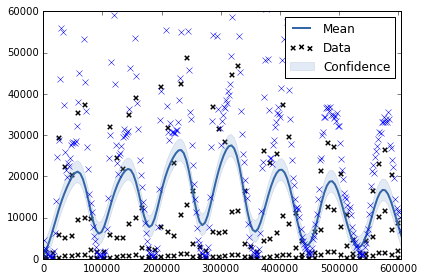

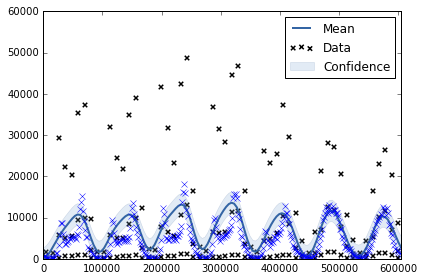

In [63]:
m_rbf.plot(fixed_inputs=[(1,600)])#,plot_data=False)
sel = point_row_form_test[:,1]==600
plt.plot(point_row_form_test[sel,0],output_row_form_test[sel]*area/area_test,'x')
plt.ylim([0,60000])
plt.xlim([0,60*60*7*24])

m_rbf.plot(fixed_inputs=[(1,1800)])#,plot_data=False)
sel = point_row_form_test[:,1]==1800
plt.plot(point_row_form_test[sel,0],output_row_form_test[sel]*area/area_test,'x')
plt.ylim([0,60000])
plt.xlim([0,60*60*7*24])

The lengthscale of the RBF kernel seems much longer, both in the direction of time-of-week and duration.

In [53]:
m_rbf.rbf.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],18516.25381409,+ve,
[1],1307.70073003,+ve,


In [41]:
m.integral.lengthscale

index,GP_regression.integral.lengthscale,constraints,priors
[0],9092.61557501,+ve,
[1],863.42883265,+ve,


### RMSE

In [54]:
## Find the sum squared error for the two methods
sse = 0
temp = []
rbf_sse = 0
for point_row,area_row,op in zip(point_row_form_test,area_row_form_test,output_row_form_test):
    [int_mean,var] = m.predict_noiseless(np.array([area_row])) 
    sse += (int_mean[0][0]-op*area/area_test)**2
    [rbf_mean,var] = m_rbf.predict_noiseless(np.array([point_row]))
    rbf_sse += (rbf_mean[0][0]-op*area/area_test)**2

In [56]:
print("Integral Kernel RMSE: %6.2f" % (np.sqrt(sse)/len(output_row_form)))
print("     RBF Kernel RMSE: %6.2f" % (np.sqrt(rbf_sse)/len(output_row_form)))

Integral Kernel RMSE: 1910.84
     RBF Kernel RMSE: 2905.94


It seems out integral kernel is doing a much better job of fitting.

I was wondering why the lengthscale for the RBF kernel is so large? Initially it looks like it could do a better job if it was smaller. But remember: It doesn't have access to the test data in the figure, only the training data (with the lower resolution). The shorter lengthscale is more useful to explain the data using the integral kernel; if one imagines constraints that the integral in one area must be X and in another area it must be Y, there's more need to 'move' more quickly to ensure these integrals are complied with. If that makes sense?

# Irrelevant other experiments

Trip duration

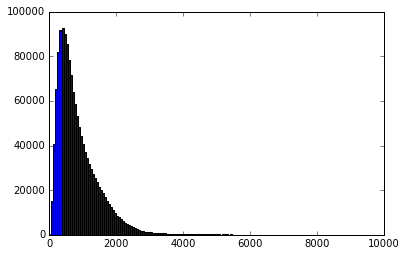

In [64]:
plt.hist(df['tripduration'],np.arange(0,10000,60));

Locations of the stations

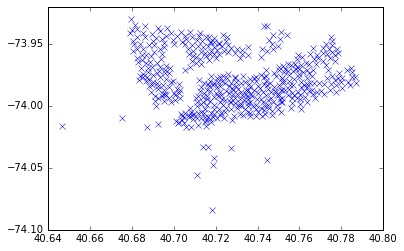

In [65]:
lats = df['end station latitude']
lons = df['end station longitude']

latlongs = set(zip(lats,lons))
if (0.0,0.0) in latlongs:
    latlongs.remove((0.0,0.0))
    
lls = np.array([[ll[0], ll[1]] for ll in latlongs])

plt.plot(lls[:,0],lls[:,1],'x')